## NGO-FUND RAISING CHURN PREDICTION

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_profiling as pp 
import seaborn as sns
#import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Creating an Excel File for output..
writer=pd.ExcelWriter('churn prediction Output.xlsx', engine='xlsxwriter')

In [55]:
extrel=pd.read_sas('data\extrel.sas7bdat')
extrelty=pd.read_sas('data\extrelty.sas7bdat')
nameaddr=pd.read_sas('nameaddr.sas7bdat')
payhistory=pd.read_sas('data\payhistory.sas7bdat')
comclas=pd.read_sas('data\comclas.sas7bdat')
commaint=pd.read_sas('data\commaint.sas7bdat')
commediu=pd.read_sas('data\commediu.sas7bdat')
communication=pd.read_sas('data\communication.sas7bdat')

In [56]:
#print extrel.info()
#print extrelty.info()
#print nameaddr.info()

   **Merging all the data**
    
    -Merging extrel,extrelty and nameaddr as one dataset.
    -Merging communication,commediu,commaint and comclas as one dataset.
    -Leaving payhistory data as it is.

In [57]:
ext=pd.merge(extrel,extrelty,how='left')
ext_data=pd.merge(ext,nameaddr,how='left')

comm1=pd.merge(communication,commediu,how='left')
comm2=pd.merge(comm1,commaint,how='left')
commu=pd.merge(comm2,comclas,how='left')


# Now the main datasets are ...
    #1.ext_data
    #2.commu
    #3.payhistory

_____

### 1.Making a list of active customers

    1A. Defining the Time Window.
            -Start of dependent window = 01 January 2006
            -End   of dependent window = 31 December 2006
            -End of independent window = 03 December 2005  

In [58]:
start_DW=np.datetime64('2006-01-01')
end_DW=np.datetime64('2006-12-31')
end_IW=np.datetime64('2005-12-03')

    1B. Subset the ext_data dataset according to the appropriate timewindow and only select donors with a commitment.
               -Select Active Customer for the Basetable.
                 -Donor is active iff:
                    1.Activity code of the donor = 'FP'
                    2.Start date before end of Independent Window ie., 03 December 2005...(Missing: not ended)
                    3.End date after start of dependent window ie., 01 January 2006...(Missing: not ended)

In [59]:
active=ext_data[ (ext_data['EXRELACTCD']=='FP') & (ext_data['EXTRELSTDT']<end_IW) & (~(ext_data['EXRELDATEN']<start_DW)) ]
active.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,EXRELACTDE,NAME1TITLE,POSTCODE,LANGUACODE
1,0026419,FP,1992-03-01,NaT,CommitmentDo,HM,2600,NL
3,0026430,FP,1992-03-01,2006-01-31,CommitmentDo,HM,2040,NL
5,0026431,FP,1992-03-01,NaT,CommitmentDo,FA,8520,NL
7,0026443,FP,1992-03-01,NaT,CommitmentDo,HM,1652,NL
8,0026444,FP,1992-03-01,NaT,CommitmentDo,MW,3001,NL


___

### 2. Creating the following Independent variables
        a.Frequency                                 e.Last Payment Date
        b.Recency                                   f.Last Communication Date
        c.Total donation per donor                  
        d.Average donation per donor          
        

    Recency: How recently a customer has made a purchase
    Frequency: How often a customer makes a purchase
    Monetary Value: How much money a customer spends on purchases

In [60]:
import datetime as dt
NOW = dt.datetime(2007,1,15) # Latest Date


################ Frequency-Recency-Monetary ######################################################

rfm_table= payhistory.groupby('EXTRELNO').agg({'PDATE': lambda x: (NOW - x.max()).days, # Recency
                                        'PID': lambda x: len(x),      # Frequency
                                        'PAMT': lambda x: x.sum()}) # Monetary Value
rfm_table.rename(columns={'PDATE': 'Recency', 
                         'PID': 'Frequency', 
                         'PAMT': 'Monetary_value'}, inplace=True)

#################### Total and Average Donation per customer##################################

avg_table=payhistory.groupby('EXTRELNO')['PAMT'].agg(['sum','mean'])
avg_table.rename(columns={'sum': 'PAMT_Total', 
                         'mean': 'PAMT_Average'}, inplace=True)

########################## last Payment Date ###################################################

last_pay=payhistory.groupby('EXTRELNO')['PDATE'].agg('max')
last_pay=pd.DataFrame(last_pay)
last_pay.rename(columns={'PDATE':'Last_pay'}, inplace=True)


########################## Last Communication info ##############################################

last_comm=commu.sort_values(ascending=0, by='CONTDATE').groupby('EXTRELNO').nth(0)
last_comm=pd.DataFrame(last_comm)
last_comm.rename(columns={'CONTDATE':'Last_communication'}, inplace=True)

# Merging the above variables.....
t1=pd.concat([rfm_table,avg_table,last_pay,last_comm],axis=1)
t1.reset_index(inplace=True)
t1.rename(columns={'index':'EXTRELNO'},inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [61]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22919 entries, 0 to 22918
Data columns (total 16 columns):
EXTRELNO              22919 non-null object
Recency               16308 non-null float64
Monetary_value        16308 non-null float64
Frequency             16308 non-null float64
PAMT_Total            16308 non-null float64
PAMT_Average          16308 non-null float64
Last_pay              16308 non-null datetime64[ns]
CLASCODE              21932 non-null object
CLASDESC              21929 non-null object
Last_communication    21932 non-null datetime64[ns]
CONTDIREC             21932 non-null object
CONTID                21932 non-null object
MEDIUMCODE            21932 non-null object
MEDIUMDESC            13406 non-null object
MNTOPCODE             21932 non-null object
MNTOPDESC             21932 non-null object
dtypes: datetime64[ns](2), float64(5), object(9)
memory usage: 2.8+ MB


_________________

### Creating the Dependent variable
          1. Create a Churn Variable.
              -[if relationship has ended, churn = 1] 

In [62]:
# Creating Variable Chrun and Start_year as follows...
active['Churn'] =np.where(active['EXRELDATEN'].isnull(), 0, 1)
active['Start_Year']=map(lambda x: x.year, active['EXTRELSTDT'])
active.to_excel(writer,'Active Customers',index=True)
active.head(2)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,EXRELACTDE,NAME1TITLE,POSTCODE,LANGUACODE,Churn,Start_Year
1,0026419,FP,1992-03-01,NaT,CommitmentDo,HM,2600,NL,0,1992
3,0026430,FP,1992-03-01,2006-01-31,CommitmentDo,HM,2040,NL,1,1992


1995    874
1993    812
2000    783
1994    747
2005    529
1999    523
2004    520
1992    436
2002    391
2001    362
1996    346
2003    304
1997    283
1998    271
Name: Start_Year, dtype: int64


Text(0.5,1,'Histogram of active customers')

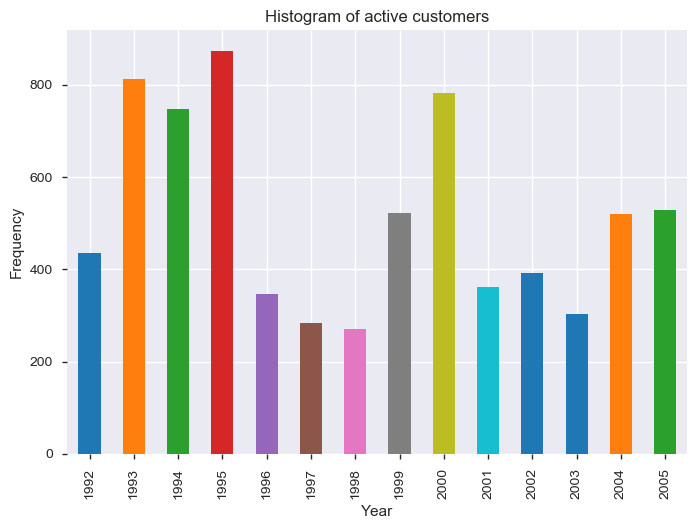

In [63]:
count=active['Start_Year'].value_counts()
print count
axes=count.sort_index().plot.bar()
axes.set_xlabel('Year')
axes.set_ylabel('Frequency')
axes.set_title('Histogram of active customers')

 -From the above Histogram, we can see that:
          -Year 1995 had most active customes with 874 customers.
          -Year 1998 had least aactive customes with 271 customers.

___________

### 4. Merge Everything and Identify Missing Values

    -Since, we already selected actvie donar in  "active" dataset from "ext_data" [extrel,extrelty,nameaddress]dataset and 
     independents variable from "payhistory" and "commu" datasets  in "t1" datasets.. 
     -Therefore, we will be merging these two datasets only.i.e., active and t1 datasets.

In [64]:
basetable=pd.merge(active,t1)

In [ ]:
basetable.to_excel(writer,'Merged Data',index=True)
basetable.info()
#basetable.head(2)

In [ ]:
axes=basetable.pivot_table(index='Start_Year', values='Churn', aggfunc='mean').plot()
axes.set_xlabel('STARTING YEAR')
axes.set_ylabel('CHURN PERCENTAGE')
axes.set_title('Churn Plot')

#### Data Description

In [ ]:
numeric_var=[key for key in dict(basetable.dtypes) if dict(basetable.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var=[key for key in dict(basetable.dtypes) if dict(basetable.dtypes)[key] in ['object']]

basetable_num=basetable[numeric_var]
basetable_cat=basetable[cat_var]

print numeric_var
print "*"*100
print cat_var

In [ ]:
# Creating Data audit Report
# Use a general function that returns multiple values    
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
 
num_summary=basetable_num.apply(lambda x: var_summary(x)).T
num_summary.to_excel(writer,'Numeric_variable Summary',index=True)
num_summary

##### Correlation 

In [ ]:
base_corr=pd.DataFrame(basetable.corr())
base_corr.to_excel(writer,'Correlation_Matrix',index=True)
base_corr.head()

#### Checking for Missing Value Variables

In [ ]:
count=0
for var in basetable:
    print var+",",
    count=count+1

print count

In [ ]:
print "*"*60
print "Variables with no. of Missing values"
for var in basetable:
    if (basetable[var].isnull().any()) ==True:
        x=basetable[var].isnull().sum()
        print ('{0}: {1} '.format(var,x))
        
print "*"*60

### 5. Imputing  Missings Values,Treating Outliers and Creating Dummy Variables

In [ ]:
pp.ProfileReport(basetable)

In [ ]:
# Droping the irrevalent variables...
drop_list=['MEDIUMDESC','EXRELACTDE','NAME1TITLE','MNTOPDESC','CLASDESC','EXRELDATEN','POSTCODE',
          'EXRELACTCD','EXTRELSTDT','CONTID','Last_pay','Last_communication','Monetary_value']

basetable.drop(drop_list,axis=1,inplace=True)

In [ ]:
print "*"*60
print "Variables with no. of Missing values"
for var in basetable:
    if (basetable[var].isnull().any()) ==True:
        x=basetable[var].isnull().sum()
        print ('{0}: {1} '.format(var,x))
        
print "*"*60

In [ ]:
# Missing Value Treatment
basetable['Recency']=basetable['Recency'].transform(lambda x: x.fillna(x.mean()))
basetable['Frequency']=basetable['Frequency'].transform(lambda x: x.fillna(x.mean()))
basetable['PAMT_Total']=basetable['PAMT_Total'].transform(lambda x: x.fillna(x.mean()))
basetable['PAMT_Average']=basetable['PAMT_Average'].transform(lambda x: x.fillna(x.mean()))
#basetable['Last_pay']=basetable['Last_pay'].transform(lambda x: x.fillna(x.max()))
#basetable['Monetary_value']=basetable['Monetary_value'].transform(lambda x: x.fillna(x.mean()))

# Basetable after Missing value treatment......
basetable.to_excel(writer,'Missing Value Treatment',index=True)

In [ ]:
basetable.isnull().sum()

###### Outlier treatment

In [ ]:
basetable.info()

In [ ]:
for col in basetable:
    dt = basetable[col].dtype 
    if dt == int or dt == float:
        basetable[col]=basetable[col].clip_upper(basetable[col].quantile(0.99))
        basetable[col]=basetable[col].clip_lower(basetable[col].quantile(0.01))
# Basetable after Outlier treatment...
basetable.to_excel(writer,'Outlier Treatment',index=True)

###### Dummy Variable creation

In [ ]:
basetable['CLASCODE'] = LabelEncoder().fit_transform(basetable['CLASCODE'])
basetable['CONTDIREC'] = LabelEncoder().fit_transform(basetable['CONTDIREC'])
basetable['MEDIUMCODE'] = LabelEncoder().fit_transform(basetable['MEDIUMCODE'])
basetable['MNTOPCODE'] = LabelEncoder().fit_transform(basetable['MNTOPCODE'])
basetable['LANGUACODE'] = LabelEncoder().fit_transform(basetable['LANGUACODE'])
#basetable['Last_pay'] = LabelEncoder().fit_transform(basetable['Last_pay'])
#basetable['Last_communication'] = LabelEncoder().fit_transform(basetable['Last_communication'])

##### Factor Analysis

In [ ]:
numeric_var=[key for key in dict(basetable.dtypes) if dict(basetable.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
basetable_num=basetable[numeric_var]
for var in basetable_num:
    if basetable_num[var].dtypes == float:
        basetable_num[var]=basetable_num[var].astype(int)

In [ ]:
basetable_num.shape

In [ ]:
factor=FactorAnalysis(11).fit(basetable_num)
F_analysis=pd.DataFrame(factor.components_,columns=numeric_var).T
F_analysis=F_analysis.add_prefix('Factor')
F_analysis.to_excel(writer,'Factor Analysis',index=True)
F_analysis.head()

----

#### Standardrizing the Data.
        - To put data on the same scale 

In [ ]:
from sklearn.preprocessing import  StandardScaler
sc=StandardScaler()
cr_scaled=sc.fit_transform(basetable)

In [ ]:
#basetable.info()

##### Applying PCA 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
basetable.shape

In [ ]:
var_ratio={}
for n in range(2,9):
    pc=PCA(n_components=n)
    cr_pca=pc.fit(cr_scaled)
    var_ratio[n]=sum(cr_pca.explained_variance_ratio_)

In [ ]:
var_ratio

    -As we can see, 7 Comonents are explaning 90% of the variance. 

In [ ]:
pc= PCA(n_components=7).fit_transform(basetable)
#pd.Series(pc.explained_variance_ratio_).plot()

---

### 6. Building Model

In [ ]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

    -Divide your data into different time windows. 
        For example: If you have data for 5 years,  
                    • Use the first 3 years to train models 
                    • validate on the 4th year and pick your best model 
                    • The 5th year’s data will be your hold-out sample for determining out-of-sample accuracy 
 

In [ ]:
print basetable.Start_Year.min()
print basetable.Start_Year.max()
diff=basetable.Start_Year.max()-basetable.Start_Year.min()
print 'Total Number of Years= '+diff.astype(str)

    -For Traning=[1992-2001]= 9 YEARS
    -For Validating=[2001-2003]= 2 YEARS
    -For Testing=[2003-2005]= 2 YEARS

In [ ]:
train=basetable[basetable.Start_Year<2001]
validation=basetable[(basetable.Start_Year>=2001) & (basetable.Start_Year<2003)]
test=basetable[basetable.Start_Year>=2003]

X_train = train.drop(['Churn'], axis=1)
Y_train = train.Churn

X_validation = validation.drop(['Churn'], axis=1)
Y_validation = validation.Churn

X_test = test.drop(['Churn'], axis=1)
Y_test = test.Churn

###### Building Model on test data.

#### 1. Logistic Regression

In [ ]:
clf_lr=LogisticRegression()
clf_lr.fit(X_train, Y_train)
lr_score_train=((accuracy_score(clf_lr.predict(X_train), Y_train))*100).round(2)
lr_score_val= ((accuracy_score(clf_lr.predict(X_validation), Y_validation))*100).round(2)
lr_score_test= ((accuracy_score(clf_lr.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , lr_score_train
print 'Validation score:' ,lr_score_val
print 'Test score:' , lr_score_test

#### 2. Decision Tree

In [ ]:
clf_dt= DecisionTreeClassifier()
clf_dt.fit(X_train, Y_train)
dt_score_train=((accuracy_score(clf_dt.predict(X_train), Y_train))*100).round(2)
dt_score_val= ((accuracy_score(clf_dt.predict(X_validation), Y_validation))*100).round(2)
dt_score_test= ((accuracy_score(clf_dt.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , dt_score_train
print 'Validation score:' ,dt_score_val
print 'Test score:' , dt_score_test

#### 3. Random Forest

In [ ]:
clf_rf= RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, Y_train)
rf_score_train=((accuracy_score(clf_rf.predict(X_train), Y_train))*100).round(2)
rf_score_val= ((accuracy_score(clf_rf.predict(X_validation), Y_validation))*100).round(2)
rf_score_test= ((accuracy_score(clf_rf.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , rf_score_train
print 'Validation score:' ,rf_score_val
print 'Test score:' , rf_score_test

#### 4. Support Vector Machine (SVM)

In [ ]:
clf_svm= SVC()
clf_svm.fit(X_train, Y_train)
svm_score_train=((accuracy_score(clf_svm.predict(X_train), Y_train))*100).round(2)
svm_score_val= ((accuracy_score(clf_svm.predict(X_validation), Y_validation))*100).round(2)
svm_score_test= ((accuracy_score(clf_svm.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , svm_score_train
print 'Validation score:' ,svm_score_val
print 'Test score:' , svm_score_test

#### 5. K -Nearest Neighbors

In [ ]:
clf_knn=KNeighborsClassifier(n_neighbors = 3)
clf_knn.fit(X_train, Y_train)
knn_score_train=((accuracy_score(clf_knn.predict(X_train), Y_train))*100).round(2)
knn_score_val= ((accuracy_score(clf_knn.predict(X_validation), Y_validation))*100).round(2)
knn_score_test= ((accuracy_score(clf_knn.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , knn_score_train
print 'Validation score:' ,knn_score_val
print 'Test score:' , knn_score_test

#### 6. Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf_nb=BernoulliNB()
clf_nb.fit(X_train, Y_train)
nb_score_train=((accuracy_score(clf_nb.predict(X_train), Y_train))*100).round(2)
nb_score_val= ((accuracy_score(clf_nb.predict(X_validation), Y_validation))*100).round(2)
nb_score_test= ((accuracy_score(clf_nb.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , nb_score_train
print 'Validation score:' ,nb_score_val
print 'Test score:' , nb_score_test

#### 7. Ada Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf_ad=AdaBoostClassifier()
clf_ad.fit(X_train, Y_train)
ad_score_train=((accuracy_score(clf_ad.predict(X_train), Y_train))*100).round(2)
ad_score_val= ((accuracy_score(clf_ad.predict(X_validation), Y_validation))*100).round(2)
ad_score_test= ((accuracy_score(clf_ad.predict(X_test), Y_test))*100).round(2)
print 'Train score:' , ad_score_train
print 'Validation score:' ,ad_score_val
print 'Test score:' , ad_score_test

###### Comparing Models
    Let's compare the accuracy score of all the classifier models used above.

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Decision Tree', 'Random Forest', 'Support Vector Machines','KNN','Naive Bayes','Ada Boosting'],
    'Train_Score'     : [lr_score_train,dt_score_train,rf_score_train,svm_score_train, knn_score_train,nb_score_train,ad_score_train],
    'Test_Score'      : [lr_score_test,dt_score_test,rf_score_test,svm_score_test, knn_score_test,nb_score_test,ad_score_test],
    'Validation_Score': [lr_score_val,dt_score_val,rf_score_val,svm_score_val, knn_score_val,nb_score_val,ad_score_val]
    })

models.sort_values(by='Train_Score', ascending=False,inplace=True)
models=models[['Model','Train_Score','Test_Score','Validation_Score']]
models

##### Choosing the Best Model and then predicting the Value using that model

<big> I choose Adaboosting because it has very less chance of overfitting than other model.

In [ ]:
y_predict=clf_ad.predict(X_test)

y_prob1=clf_ad.predict_proba(X_test)
y_prob=pd.DataFrame(y_prob1)
y_prob2=list(y_prob[1])

In [ ]:
submission = pd.DataFrame({
        "EXTRELNO": test["EXTRELNO"],
        "Churn": y_predict,
        "Churn Probability":y_prob2,
        "Start_Year": test["Start_Year"]})
submission=submission[['EXTRELNO','Churn','Churn Probability','Start_Year']]
submission.to_csv('submission_AdaBoosting.csv', index=False)
submission.to_excel(writer,'submission_AdaBoosting', index=False)

In [ ]:
submission.head()

#### Variable Importance

In [ ]:
ce=pd.DataFrame(clf_ad.feature_importances_, X_train.columns)
ce.columns=['Coefficients%']
ce.sort_values('Coefficients%',ascending=False,inplace=True)
ce['Coefficients%']=((ce['Coefficients%'])*100).round(2)
ce.to_excel(writer,'Variable_importance',index=True)

In [ ]:
ce

In [ ]:
ce=ce.head(6)
ce['Coefficients%'].plot(kind='barh')

    ************************ THE END ***********************************************************************************

.